In [1]:
BASE_FILENAME = 'gen3'

In [2]:
import xmltodict, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [3]:
# 与えられたnode idから対応するX,Yの点を返す関数
def findXY(node_id):
    for node in nodes:
        if node['@nid'] == str(node_id):
            return (node['@x'], node['@y'])
            
# 4点から面積を計算する方法（靴紐の公式））
def shoelace_area(points):
    """
    計算順に並んだ4点の(x, y)座標リスト [(x1, y1), (x2, y2), (x3, y3), (x4, y4)] から面積を求める
    """
    n = len(points)
    area = 0
    for i in range(n):
        j = (i + 1) % n  # 次の点（最後の点は最初の点につなげる）
        area += points[i][0] * points[j][1] - points[i][1] * points[j][0]
    return abs(area) / 2

# ✅ 例: 4点を指定して計算
points = [(1, 1), (4, 1), (4, 5), (1, 5)]  # 長方形
# print(shoelace_area(points))  # 出力: 12.0

In [4]:
data = 'input/'+BASE_FILENAME+'.liml'

In [5]:
import xmltodict
import pprint

# Open the file and read the contents
with open(data,  'r', encoding='utf-8') as file:
    my_xml = file.read()

# Use xmltodict to parse and convert 
# the XML document
my_dict = xmltodict.parse(my_xml).copy()

# Print the dictionary
pprint.pprint(my_dict, indent=2)


{ 'liml8': { 'analysis': {'@type': 'S20'},
             'displacement': [ { '@axis': '1',
                                 '@selection': 'Unnamed',
                                 'value': '0'},
                               { '@axis': '2',
                                 '@selection': 'Unnamed(2)',
                                 'value': '0'}],
             'elset': [ { '@color': '-6710887',
                          '@material': 'Material',
                          '@name': 'Default'},
                        { '@color': '-6710887',
                          '@material': 'Material1',
                          '@name': 'Component1',
                          'elem': { '@eid': '1',
                                    '@nodes': '1243 1269 3 1244',
                                    '@shape': 'quad4'}},
                        { '@color': '-6710887',
                          '@material': 'Material2',
                          '@name': 'Component2',
                          'elem

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [6]:
def calc_g(rhos):
    g = np.dot(rhos, vs.transpose()) - a*V0
    return g 

In [7]:
def calc_rho_i(lmbda, sigma_i):
    rho_i = (-(n-1)/E0 * np.dot(nu*sigma_i, sigma_i.transpose())  / lmbda ) ** (1/n)
    if rho_i > 1:
        rho_i = 1 
    elif rho_i < 0.01:
        rho_i = 0.01
    return rho_i 

In [8]:
def calc_D(rho_i, lmbda, sigma_i):
    D = -lmbda * E0 * rho_i**n / ((n-1) * np.dot(nu*sigma_i, sigma_i.transpose()))
    return D

In [9]:
def update_rho_i(rho_i, lmbda, sigma_i):
    D = calc_D(rho_i, lmbda, sigma_i)
    while abs(D-1) > 1e-3:
        if D > 1:
            rho_i = rho_i - drho 
        else:
            rho_i = rho_i + drho
        if rho_i > 1:
            rho_i = 1 
            break 
        elif rho_i < 0.01:
            rho_i = 0.01
            break 
        D = calc_D(rho_i,lmbda, sigma_i)
    return rho_i

In [10]:
def update_lambda(g, lmbda):
    if g<0:
        lmbda = lmbda - dlambda #ラムダを右にシフト
        if lmbda > 0:
            lmbda = lmbda + dlambda #λは正にならないので、もし正になったら負に戻す
    else:
        lmbda = lmbda + dlambda #ラムダを左にシフト
    return lmbda 

In [11]:
def check_if_all_rhos_are_settled(rhos):
    for i in range(ne):
        if (rhos[i] == 1) or (rhos[i] == 0.01):
            continue
        else:
            return False
    return True

In [12]:
# グローバルなパラメータ
a = 0.375
E0 = 200e9
n = 2 #3が適当??
nu = 0.3

0th element
  g is almost zero
1th element
  g is almost zero
2th element
  g is almost zero
3th element
  g is almost zero
4th element
  g is almost zero
5th element
  g is almost zero
6th element
  g is almost zero
7th element
  g is almost zero
8th element
  g is almost zero
9th element
  g is almost zero
10th element
  g is almost zero
11th element
  g is almost zero
12th element
  g is almost zero
13th element
  g is almost zero
14th element
  g is almost zero
15th element
  g is almost zero
16th element
  g is almost zero
17th element
  g is almost zero
18th element
  g is almost zero
19th element
  g is almost zero
20th element
  g is almost zero
21th element
  g is almost zero
22th element
  g is almost zero
23th element
  g is almost zero
24th element
  g is almost zero
25th element
  g is almost zero
26th element
  g is almost zero
27th element
  g is almost zero
28th element
  g is almost zero
29th element
  g is almost zero
30th element
  g is almost zero
31th element
  g i

Text(0, 0.5, 'lambda')

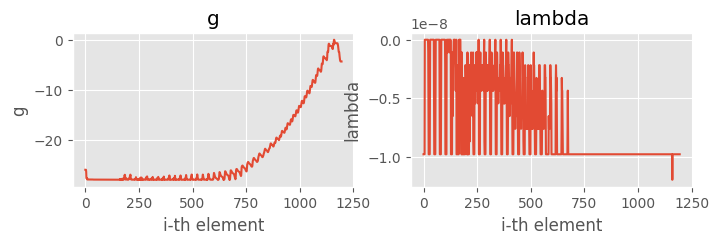

In [13]:
#要素リストの抽出
elset = my_dict['liml8']['elset'].copy()
if type(elset)==dict:
    elem_list = elset['elem']
elif type(elset)==list:
    elem_list = []
    for e in elset:
        if "elem" in e:
            elem_list.append(e['elem'])
# FEMの結果を変数に格納
nodes = my_dict['liml8']['node'].copy() #nodes
result_elems = my_dict['liml8']['solution']['results']['elem'].copy()
ne = len(elem_list)
sigmas = np.zeros((ne,3))
# ρの初期化。初回か２回目以降かで異なる。
if type(elset)==dict: #初回
    rhos = np.ones(ne) * a #初回はすべて平均値のaで代替する。
elif type(elset)==list: #２回目以降
    mat_list = my_dict['liml8']['mat'].copy()
    E = np.array([x['mechanical']['@youngsmodulus'] for x in mat_list[1:]], dtype=np.double)
    rhos = (E/E0) ** (1/n)
Es = np.zeros(ne)
vs = np.zeros(ne)
cxs = np.zeros(ne)
cys = np.zeros(ne)
# Load stress from each element
lambda_tmp = 0
for i in range(ne):
    Es[i] = rhos[i]**n * E0
    sigma_x = np.array(list(map(lambda x: x['@stressxx'], result_elems[i]['localnode'])),dtype=np.double).sum()
    sigma_y = np.array(list(map(lambda x: x['@stressyy'], result_elems[i]['localnode'])),dtype=np.double).sum()
    tau_xy = np.array(list(map(lambda x: x['@stressxy'], result_elems[i]['localnode'])),dtype=np.double).sum()
    sigmas[i] = np.array([sigma_x,sigma_y,tau_xy])
    lambda_tmp += np.dot(nu*sigmas[i], sigmas[i].transpose())/(rhos[i]**n)
    node_ids = elem_list[i]['@nodes'].split(' ')
    vertices = np.zeros((4, 2))
    n_nodes_in_elems = len(node_ids)
    for j in range(n_nodes_in_elems):
        (x,y) = findXY(node_ids[j])
        vertices[j, :] = (x,y)
    vs[i] = shoelace_area(vertices)
    cxs[i] = vertices[:,0].sum() / n_nodes_in_elems 
    cys[i] = vertices[:,1].sum() / n_nodes_in_elems 

# トータルの体積V0
V0 = vs.sum()  
# lambda_barはlmbdaの初期値
lambda_bar = -1/ne*(n-1)/E0 * lambda_tmp     
lmbda = lambda_bar
dlambda = 0.1 * lambda_bar
drho = 0.05

tolerance = 0.01 
g_prev = 0
g_res = []
l_res = []
is_dump_enabled = True
for i in range(ne):
    if is_dump_enabled: print(str(i)+'th element')
    lmbda = lambda_bar
    # λを更新するアウターループ
    while True:
        # λにしたがってρiを計算する
        rhos[i] = calc_rho_i(lmbda, sigmas[i])
        # ρを更新するインナーループ
        rhos[i] = update_rho_i(rhos[i], lmbda, sigmas[i])
        if check_if_all_rhos_are_settled(rhos): 
            if is_dump_enabled: print("***All rhos are settled.***") 
            break 
        g = calc_g(rhos)
        lmbda = update_lambda(g, lmbda)
        if g==g_prev: #gに変化が見られない場合、λの最適解と判定、
            if is_dump_enabled: print("  No change in g.") 
            break
        if abs(g/V0) < tolerance: #gが0に近づいたらλの最適解と判定
            if is_dump_enabled: print("  g is almost zero") 
            break
        if g*g_prev< 0: #gの符号が変わったらラムダの最適解と判定
            if is_dump_enabled: print("  Sign of g changed.") 
            break
        g_prev = g
    # if is_dump_enabled: print(f"  g/V0: {g/V0}, λ:{lmbda}") 
    g_res.append(g)
    l_res.append(lmbda)
    if(rhos[i]>1):
        print('warning: rho > 1')
plt.rcParams['figure.figsize'] = [8, 2]
plt.subplot(1,2,1)    
plt.plot(range(ne), g_res)
plt.title('g')
plt.xlabel('i-th element')
plt.ylabel('g')
plt.subplot(1,2,2)    
plt.plot(range(ne), l_res)
plt.title('lambda')
plt.xlabel('i-th element')
plt.ylabel('lambda')


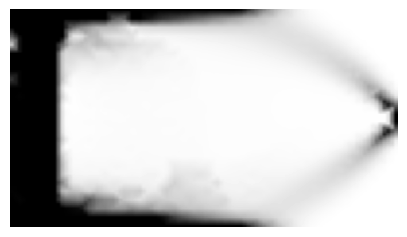

In [14]:
Ei = (rhos**n) * E0
[X,Y] = np.meshgrid(np.linspace(min(cxs),max(cxs),100),np.linspace(min(cys),max(cys),100))
points = np.concatenate((cxs[:, np.newaxis] , cys[:, np.newaxis]), axis=1)
Z = griddata(points,-Ei,(X,Y))
plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots() 
plt.axis('off')
img = ax.imshow(Z, extent=[min(cxs), max(cxs), min(cys), max(cys)])
img.set_cmap('gray')

In [15]:
# マテリアルの情報を更新する
mat_base = my_dict['liml8']['mat'].copy()
if type(mat_base)==list:
    mat_base = mat_base[0]
id_base = mat_base['@mid']
name_base = mat_base['@name']
geo_base = mat_base['geometric']
mech_base = mat_base['mechanical'] 
mat_new = [mat_base.copy()]
for i in range(ne):
    mat_dict = {}
    mat_dict['@mid'] = str(int(id_base) + i + 1)
    mat_dict['@name'] = name_base + str(int(id_base) + i)
    mat_dict['geometric'] = geo_base.copy()
    mat_dict['mechanical'] = mech_base.copy()
    # Update Young's modulus
    mat_dict['mechanical']['@youngsmodulus'] = "{:.0f}".format(Ei[i])
    mat_new.append(mat_dict)


In [16]:
# 要素のマテリアル情報を更新する
elem_base = my_dict['liml8']['elset'].copy()
if type(elem_base)==list:
    elem_base = elem_base[0]
elem_base.pop('elem', None) # Remove "elem" key
elset_new = [elem_base]
for i in range(ne):
    elem = elem_list[i]
    elem_dict = elem_base.copy() 
    elem_dict['elem'] = elem
    elem_dict['@name'] = 'Component'  + str (i + 1)
    elem_dict['@material'] = elem_base['@material'] + str(i + 1)
    elset_new.append(elem_dict)

In [17]:
#結果の更新
my_dict_new = my_dict.copy()
my_dict_new['liml8']['elset'] = elset_new
my_dict_new['liml8']['mat'] = mat_new

liml = xmltodict.unparse(my_dict_new, pretty=True, full_document=False)
output_filename = 'output/'+BASE_FILENAME+'_out.liml'
fout = open(output_filename, 'w')
fout.write(liml)
fout.close()

In [18]:
# 第２世代のサンプル確認用
# data2 = 'liml/beam1_opti_2.liml'
# with open(data2,  'r', encoding='utf-8') as file:
#     my_xml2 = file.read()
# my_dict2 = xmltodict.parse(my_xml2)
# len(my_dict2['liml8']['mat'])